In [161]:
pip install easyocr

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import easyocr
import os

In [163]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [164]:
img_path = "/content/gdrive/MyDrive/FinalImages/"  # enter path of finalImages folder here
L = []
for images in sorted(os.listdir(img_path)):    
    img = cv2.imread(img_path+images)
    L.append(img)

In [165]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [166]:
# !unzip "/FinalImages.zip"

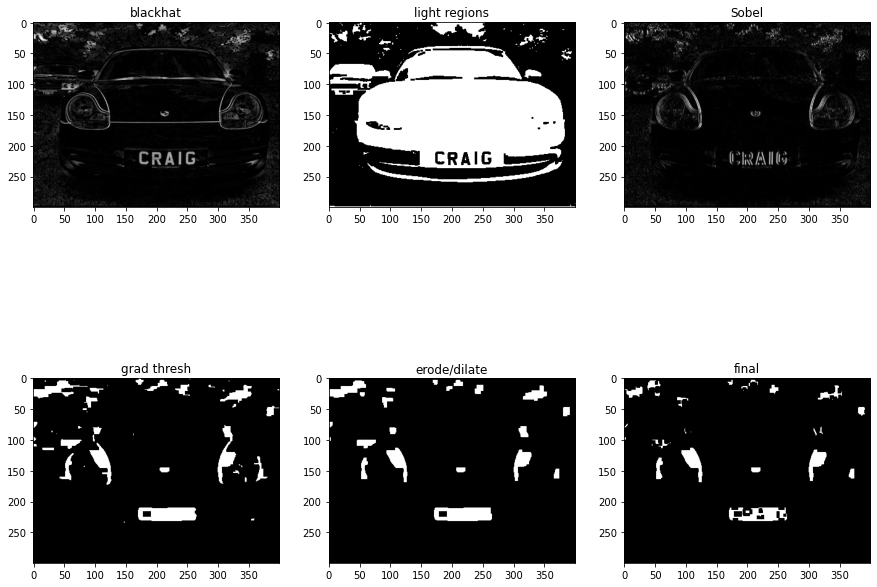

In [167]:
fig,axis = plt.subplots(2,3, figsize = (15,12))
class LicenseDetection:
    def __init__(self, minAR=0.5):

        self.minAR = minAR
    
    def detectLicensePlate(self, gray):
        # blackhat morphological operation (Reveal dark regions(text) on light background(license Plate))
        kernel1 = np.ones((5,13), np.uint8)
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel1)
        axis[0,0].imshow(blackhat, cmap = 'gray')
        axis[0,0].set_title("blackhat")
        
        # find light region in image (one of the light region is the license plate)
        kernel2 = np.ones((3,3), np.uint8)
        light_region = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel2)
        ret, light_region = cv2.threshold(light_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        axis[0,1].imshow(light_region, cmap = 'gray')
        axis[0,1].set_title("light regions")

        # compute the Sobel gradient representation of the blackhat image and scale the result back to the range [0, 255]
        gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        gradX = 255 * ((gradX - np.min(gradX)) / (np.max(gradX) - np.min(gradX)))
        gradX = gradX.astype("uint8")
        axis[0,2].imshow(gradX, cmap = 'gray')
        axis[0,2].set_title("Sobel")

        # blur the gradient representation, applying a closing operation, and threshold the image using Otsu's method
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, kernel1)
        ret, thresh_gradX = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        axis[1,0].imshow(thresh_gradX, cmap = 'gray')
        axis[1,0].set_title("grad thresh")

        # perform erosions and dilations to clean up the thresholded image
        thresh_gradX = cv2.erode(thresh_gradX, None, iterations=2)
        thresh_gradX = cv2.dilate(thresh_gradX, None, iterations=2)
        axis[1,1].imshow(thresh_gradX, cmap = 'gray')
        axis[1,1].set_title("erode/dilate")

        # take the bitwise AND between the threshold result and the light regions of the image
        thresh_gradX = cv2.bitwise_and(thresh_gradX, thresh_gradX, mask=light_region)
        thresh_gradX = cv2.dilate(thresh_gradX, None, iterations=2)
        thresh_gradX = cv2.erode(thresh_gradX, None, iterations=2)
        axis[1,2].imshow(thresh_gradX, cmap = 'gray')
        axis[1,2].set_title("final")

        # find contours in the thresholded image 
        cnts = cv2.findContours(thresh_gradX.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        licenses = []
        for c in cnts:
             # compute the bounding box of the contour
             (x, y, w, h) = cv2.boundingRect(c)
             ar = w*float(h)

             # check to see if the area is greater than threshold
             if ar >= self.minAR:

                 licensePlate = gray[y:y + h, x:x + w]
                 licenses.append(licensePlate)
              # epsilon = 10
              # approx = cv2.approxPolyDP(c, epsilon, True)
              # if len(approx) == 4:
              #     (x, y, w, h) = cv2.boundingRect(approx)
              #     licensePlate = gray[y:y + h, x:x + w]
              #     licenses.append(licensePlate)
                  
                  
        return licenses

lic = LicenseDetection()
img = cv2.imread("Cars426.png")  #enter image path here
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

licenses = lic.detectLicensePlate(gray=gray)

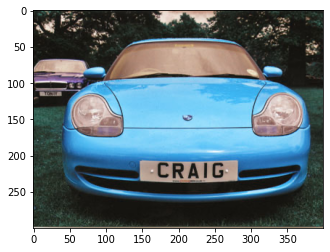

In [168]:
plt.imshow(img)

In [169]:
def calculate_median(array):
    """Return the median of 1-d array"""
    sorted_array = np.sort(array) #timsort (O(nlogn))
    median = sorted_array[array.shape[0]//2]
    return median
def level_A(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_med < z_max):
        return level_B(z_min, z_med, z_max, z_xy, S_xy, S_max)
    else:
        S_xy += 2 #increase the size of S_xy to the next odd value.
        if(S_xy <= S_max): #repeat process
            return level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
        else:
            return z_med
def level_B(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_xy < z_max):
        return z_xy
    else:
        return z_med

In [170]:
def amf(image, initial_window, max_window):
    """runs the Adaptive Median Filter proess on an image"""
    xlength, ylength = image.shape #get the shape of the image.
    
    z_min, z_med, z_max, z_xy = 0, 0, 0, 0
    S_max = max_window
    S_xy = initial_window #dynamically to grow
    
    output_image = image.copy()
    
    for row in range(S_xy, xlength-S_xy-1):
        for col in range(S_xy, ylength-S_xy-1):
            filter_window = image[row - S_xy : row + S_xy + 1, col - S_xy : col + S_xy + 1] #filter window
            target = filter_window.reshape(-1) #make 1-dimensional
            z_min = np.min(target) #min of intensity values
            z_max = np.max(target) #max of intensity values
            z_med = calculate_median(target) #median of intensity values
            z_xy = image[row, col] #current intensity
            
            #Level A & B
            new_intensity = level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
            output_image[row, col] = new_intensity
    return output_image

In [171]:
from skimage.transform import radon
def approx_angle(blur):   #calculates the angle of the motion blur
  blur_lic = np.log(np.abs(np.fft.fftshift(np.fft.fft2(blur))))  #spectrum
  adp_lic = amf(blur_lic, 3,11)     #adaptive median filtering(to reduce noise)
  adp_lic = np.where(adp_lic>7, 1, 0)    #thresholding
  rad = radon(adp_lic)  #radon transformation
  max_array = [np.mean(np.partition(rad[:,i], -3)[-3:]) for i in range(180)]   #mean of each angle
  ang = np.argmax(max_array)*blur.shape[0]/blur.shape[1]
  return blur_lic, adp_lic, rad, ang

In [172]:
def make_square(img):
  if(img.shape[0]>img.shape[1]):
    return None
  
  PAD = [255,255,255]
  shape = img.shape
  img= cv2.copyMakeBorder(img.copy(),(img.shape[1] - img.shape[0])//2 +2,(img.shape[1] - img.shape[0])//2+2,2,2,cv2.BORDER_CONSTANT,value=PAD)
  return img

In [173]:
from scipy.signal import argrelmax, argrelmin
def approx_length(blur):
  blur_lic = np.log(np.abs(np.fft.fftshift(np.fft.fft2(blur))))    #spectrum
  h, w = blur_lic.shape
  (cX, cY) = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D((cX, cY), -ang, 1.0)
  rotated = cv2.warpAffine(blur_lic, M, (w, h))    # rotate spectrum with the angle obtained above
  avg_cepstrum = np.array([np.mean(rotated[:, i]) for i in range(rotated.shape[1])])

  mx = np.argmax(avg_cepstrum)   # calculate the approx length
  count = 1
  while(mx+count+2<len(avg_cepstrum) and avg_cepstrum[mx+count]>avg_cepstrum[mx+count+2]):
    count+=2
  i = 1
  while(mx-i-2>0 and avg_cepstrum[mx-i]>avg_cepstrum[mx-i-2]):
    # print(i)
    i+=2
  return np.ceil(blur.shape[0]/(count+i))

In [174]:
def Richardson_Lucy(input_img, psf,estimate = -1,t = 60,bit_depth_format = 'uint8', reg_param = -1, damping_factors=(-1,-1)):
    D = input_img.astype(float)   #D is the inputted noisy, blurred image
    
    P = psf  #P is the known psf of the blur applied to original image
    t = t # no. of iterations of LR algorithm
    
    if(type(estimate)==int):
        O = D.copy()   #O is the estimated original image (updated with every iteration), we by default set initial estimate to be the input image itself

    else:
        O = estimate.astype(float)
    
    
    I = cv2.filter2D(O,-1,P).astype(float)  # O convolved with P
    
    I += I.max() * 1E-6
    D+= D.max() * 1E-6      # This small number is added to prevent error due to division by zero
    
    # Damping factors
    N = damping_factors[0]  # determines how fast the damping function flattens, should be greater than a small number for ideal functioning
    T = damping_factors[1]   # determines the threshold level in terms of the standard deviation of the psf
    
    alpha = reg_param   # regularization parameter used to estimate the optimal number of iterations

    if alpha!=-1:
        e = 0.5 * np.linalg.norm(D - I)**2 + alpha * (np.linalg.norm(np.divide(O-D,D))**2)
        # e is the error from optimization function
    
    #Begin RL deconvolution
    i=0
    while(i<t):
        
        # Section for damping
        if(damping_factors != (-1,-1)):         
            D = (D + D.max() * 1E-6).astype(float)
            U = -2/T/T * (np.multiply(D,np.log(np.divide(I,D))) - I + D)
            U[U>1]=1
            U_N_1 = np.power(U,N-1)  
            convolved_factor = np.ones(D.shape) + np.multiply(N * U_N_1 - (N-1)*np.multiply(U_N_1,U) , np.divide(D-I,I))
        else:
            convolved_factor = np.divide(D,I)
        
        #Iteration for RL deconvolution
        O_new = np.multiply(O,cv2.filter2D(convolved_factor, -1,cv2.flip(P,-1)))
        I_new = cv2.filter2D(O_new,-1,P).astype(float)
        I_new += I_new.max() * 1E-6
        
        #Section for regularization
        if alpha!=-1:
            e_new = 0.5 * np.linalg.norm(D-I_new)**2 + alpha * (np.linalg.norm(np.divide(O_new-D,D))**2)
            if e_new > e:   #If error function increases, stop
                return O.astype(bit_depth_format),i
            e = e_new
        
        I = I_new
        O = O_new   #Update I and O
        i+=1
        
    return O.astype(bit_depth_format),i

In [175]:
	def make_motion_psf(length,ang):
      length = int(length)
      size = int(length)
      h = np.zeros((size, size))
      h[int((size-1)/2),:] = np.ones(size)
      h = h / size 
      (cX, cY) = (length // 2, length // 2)
      M = cv2.getRotationMatrix2D((cX, cY), -ang, 1.0)
      psf = cv2.warpAffine(h, M, (length, length))
      return psf

In [176]:
for r in licenses:
      result = reader.readtext(r)
      if result:
        text = str.upper(result[0][1])
        print(text, "ok")
      else: #Check for blurring if no text is detected
        rs = make_square(r)
        if (type(rs)!=np.ndarray): 
          continue
        from skimage.filters import window
        rs = rs * window('hann', rs.shape)
        blur_lic, adp_lic, rad,ang = approx_angle(rs)
        length = approx_length(rs)
        psf = make_motion_psf(length,ang)
        deblurred, _ = Richardson_Lucy(r,psf, reg_param=5)
        result = reader.readtext(deblurred)
        if result:
          text = str.upper(result[0][1])
          print(text, "ok")


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


CRAIG ok


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


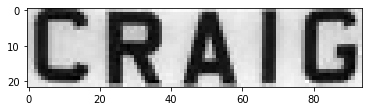

In [177]:
plt.imshow(licenses[1], cmap = 'gray')

In [178]:
# np.shape(licenses)

In [179]:
car = 1
for i in L:
    gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)

    licenses = lic.detectLicensePlate(gray=gray)
   
    for r in licenses:
      result = reader.readtext(r)
      if result:
        text = str.upper(result[0][1])
        print(car,text)
    car+=1

1 4
1 7A2555
2 PGOMN112
3 AHO 1478866
4 35"
4 32
4 VMK
6 DURZIG
8 IVIGZ6J
10 15-LK-10898
10 14
11 DURZIG
12 0Z6-SPF-4
13 KL54 42670
13 S
15 BYOND
15 LIVIN
16 IRU
17 ZONS
17 IUSR
17 795 4523
18 MAM
19 HR 26 BC 5514
20 WU
21 DAN 54P
22 STOMP
24 DZI7 YXR
25 OMP
25 G0SI
26 TESLALICENSEPLALEINSWEDEN O
27 MOO
27 MH 20 EJ0364
28 DLZC N 5617
29 15-LK-10898
29 14
30 00A BREKKE 2017
30 AB 44 887
31 HH15BD8877
32 DOI-RLJ
34 VIPER
36 WU
37 CRAIG
38 CHIO OSE
38 ))
39 HATT UP
39 @L
40 HR 26CU6799
42 HEEIRILL
43 AHO 1478866
